<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparations" data-toc-modified-id="Preparations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparations</a></span><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Models" data-toc-modified-id="Models-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Models</a></span></li><li><span><a href="#Loading-Pretrained" data-toc-modified-id="Loading-Pretrained-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Loading Pretrained</a></span></li></ul></li><li><span><a href="#Understanding-the-first-Layer" data-toc-modified-id="Understanding-the-first-Layer-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Understanding the first Layer</a></span></li><li><span><a href="#Loosing-Translation-Equivariance-with-Large-Receptive-Field" data-toc-modified-id="Loosing-Translation-Equivariance-with-Large-Receptive-Field-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Loosing Translation Equivariance with Large Receptive Field</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Missing-at-Random" data-toc-modified-id="Missing-at-Random-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Missing at Random</a></span></li><li><span><a href="#Structured-Missing" data-toc-modified-id="Structured-Missing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Structured Missing</a></span><ul class="toc-item"><li><span><a href="#Horizontal-Half-Mask" data-toc-modified-id="Horizontal-Half-Mask-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Horizontal Half Mask</a></span></li><li><span><a href="#Vertical-Half-Mask" data-toc-modified-id="Vertical-Half-Mask-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Vertical Half Mask</a></span></li></ul></li><li><span><a href="#Oneshot-Prediction" data-toc-modified-id="Oneshot-Prediction-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Oneshot Prediction</a></span></li><li><span><a href="#Autoregressive-Prediction" data-toc-modified-id="Autoregressive-Prediction-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Autoregressive Prediction</a></span></li></ul></div>

# ICLR Notes

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = True # can also be set in the trainer

## Preparations

In [2]:
cd ..

/private/home/yannd/projects/Neural-Process-Family


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


### Dataset 

In [10]:
from utils.data import get_dataset
from utils.data.helpers import train_dev_split
from utils.visualize import plot_dataset_samples_imgs, plot_losses #, plot_posterior_samples_imgs

In [11]:
_= get_dataset("celeba")()

In [37]:
len(zs_mmnist_test)

10000

In [12]:
celeba32_train, celeba32_test = train_dev_split(get_dataset("celeba32")(), dev_size=0.1, is_stratify=False)
celeba64_train, celeba64_test = train_dev_split(get_dataset("celeba64")(), dev_size=0.1, is_stratify=False)
svhn_train, svhn_test = get_dataset("svhn")(split="train"), get_dataset("svhn")(split="test")
mnist_train, mnist_test = get_dataset("mnist")(split="train"), get_dataset("mnist")(split="test")
zs_mmnist_train, zs_mmnist_test = get_dataset("zs-multi-mnist")(split="train"), get_dataset("zs-multi-mnist")(split="test")

# celeba64 not fully trained yet
train_datasets_32 = {"mnist":mnist_train, "celeba32":celeba32_train}
test_datasets_32 = {"mnist":mnist_test, "celeba32":celeba32_test}
train_datasets_64 = {"celeba64":celeba64_train, "zs-multi-mnist":zs_mmnist_train}
test_datasets_64 = {"celeba64":celeba64_train, "zs-multi-mnist":zs_mmnist_test}

Using downloaded and verified file: /private/home/yannd/projects/Neural-Process-Family/utils/data/../../data/train_32x32.mat
Using downloaded and verified file: /private/home/yannd/projects/Neural-Process-Family/utils/data/../../data/test_32x32.mat


INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...


In [13]:
from neuralproc.utils.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker

# same as in previous tutorials but uses masks rather than indices
get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.5),
                                      target_masker=no_masker,
                                      is_add_cntxts_to_trgts=False)

### Models

In [14]:
X_DIM = 2  # 2D spatial input 

In [15]:
from functools import partial
from neuralproc import RegularGridsConvolutionalProcess, AttentiveNeuralProcess, NeuralProcessLoss, ConvolutionalProcess
from neuralproc.predefined import UnetCNN, CNN, SelfAttention, MLP, ResConvBlock
from neuralproc import merge_flat_input

In [33]:
from train_imgs import get_model

models_grided = {}
models_grided["GridedCCP"] = get_model("GridedCCP", n_blocks=7, kernel_size=11, init_kernel_size=11, img_shape=(64,64))


In [35]:
from utils.helpers import count_parameters

count_parameters(models_grided["GridedCCP"](y_dim=3))

407927

In [91]:
def add_y_dim(models, datasets):
    """Add y _dim to all ofthe models depending on the dataset."""
    return {data_name: {model_name: partial(model, y_dim=data_train.shape[0]) 
                        for model_name, model in models.items()} 
            for data_name, data_train in datasets.items()}

### Loading Pretrained

In [92]:
from neuralproc import NeuralProcessLoss
from utils.train import train_models
from utils.data import cntxt_trgt_collate
import skorch

kwargs = dict(chckpnt_dirname="results/iclr_imgs/", 
             is_retrain=False, 
             train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
             iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt), 
             iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),
             patience=10,
             batch_size=16,
             seed=123)

trainers_grided_64 = train_models(train_datasets_64, 
                                 add_y_dim(models_grided_64, train_datasets_64),
                                 NeuralProcessLoss,
                                 **kwargs) 

trainers_grided_32 = train_models(train_datasets_32, 
                                 add_y_dim(models_grided_32, train_datasets_32),
                                 NeuralProcessLoss,
                                 **kwargs) 


--- Loading celeba64/GridedCCP/run_0 ---

celeba64/GridedCCP/run_0 | best epoch: 31 | train loss: -3.6639 | valid loss: -3.7307 | test log likelihood: None

--- Loading celeba64/GridedCCP_large/run_0 ---



FileNotFoundError: [Errno 2] No such file or directory: 'results/iclr_imgs/celeba64/GridedCCP_large/run_0/history.json'

## Understanding the first Layer

In [26]:
trainers_grided_64['celeba64/GridedCCP/run_0'].module_.pseudo_transformer

CNN(
  (conv_blocks): ModuleList(
    (0): ResConvBlock(
      (activation): ReLU()
      (norm1): Identity()
      (conv1): DepthSepConv(
        (depthwise): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=128)
        (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (norm2): Identity()
      (conv2_depthwise): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=128)
      (conv2_pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ResConvBlock(
      (activation): ReLU()
      (norm1): Identity()
      (conv1): DepthSepConv(
        (depthwise): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=128)
        (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (norm2): Identity()
      (conv2_depthwise): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=128)
      (conv2_pointwise): Conv2d(128, 128, kerne

In [44]:
avg_weights_celeba64 = trainers_grided_64['celeba64/GridedCCP/run_0'].module_.conv.weight.squeeze().mean(0).abs()

In [53]:
trainers_grided['{}/GridedCCP/run_0'.format(d)].module_.conv.weight.shape

torch.Size([1, 1, 7, 7])

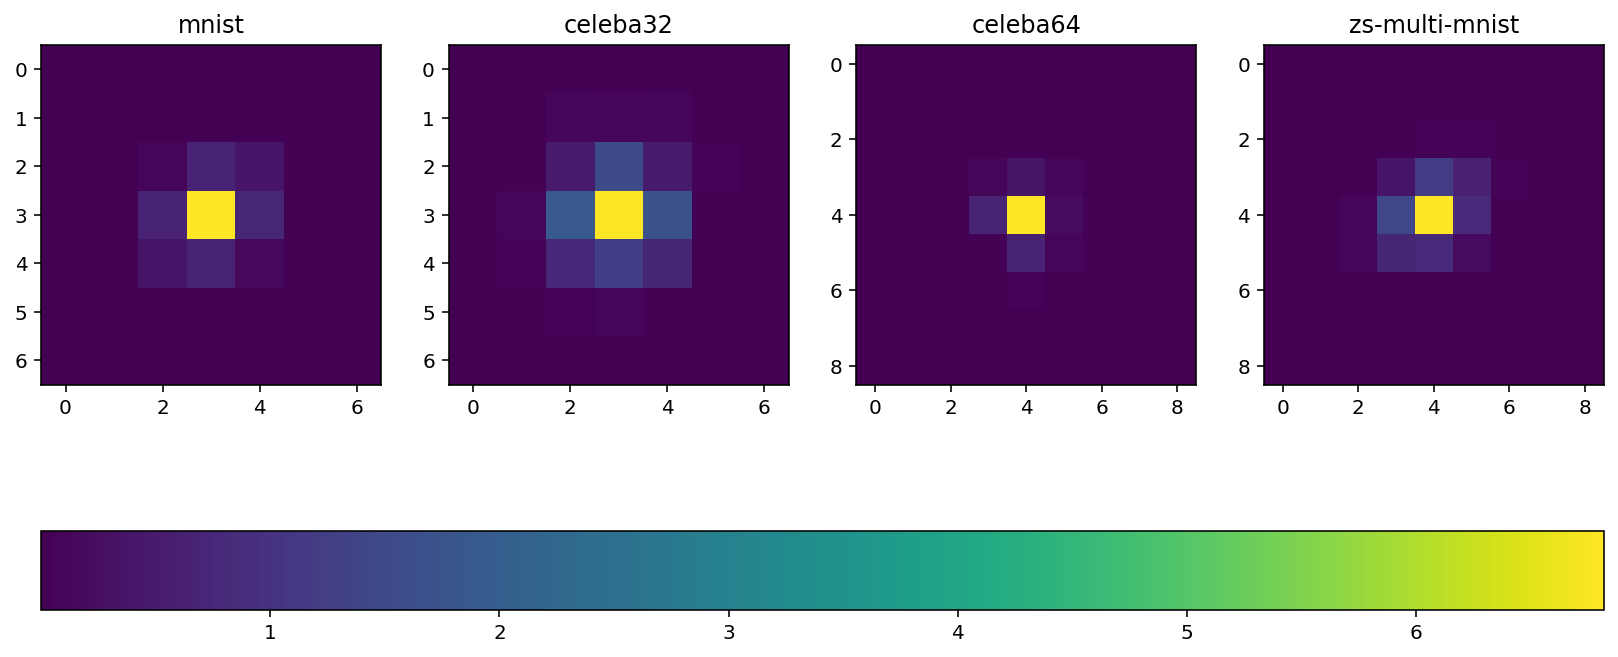

In [85]:
trainers_grided = trainers_grided_64.copy()
trainers_grided.update(trainers_grided_32)

dataset = ["mnist", "celeba32", "celeba64", "zs-multi-mnist"]
fig, axes = plt.subplots(1,len(dataset), figsize=(14,9))

for i, d in enumerate(dataset):
    # use abs because I force positive weights in my implementation
    weights_layer_1 = trainers_grided['{}/GridedCCP/run_0'.format(d)].module_.conv.weight.squeeze(1).mean(0).abs()
    im = axes[i].imshow(weights_layer_1.detach().numpy())
    axes[i].set_title(d)
    

fig.colorbar(im,  orientation="horizontal", ax=axes.ravel().tolist())

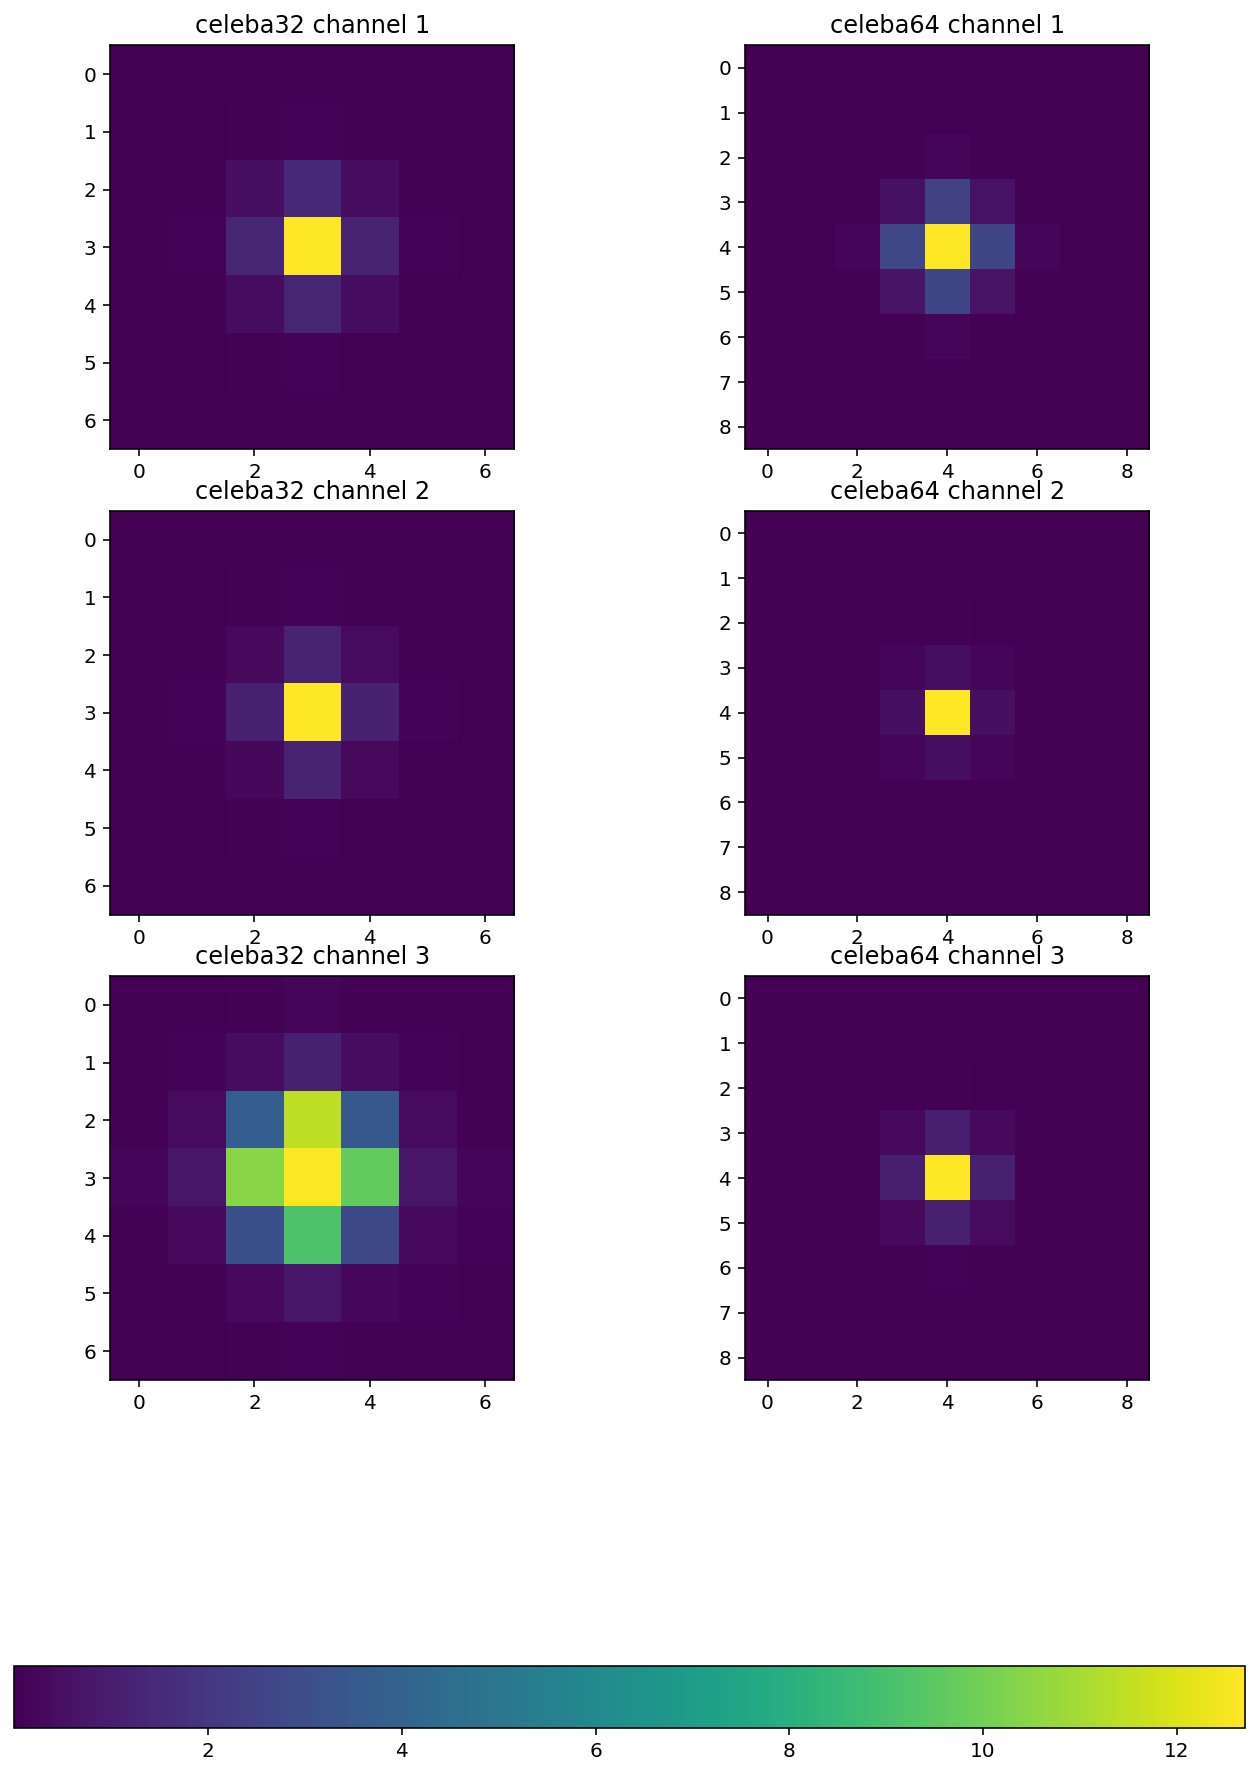

In [89]:
trainers_grided = trainers_grided_64.copy()
trainers_grided.update(trainers_grided_32)

dataset = ["celeba32", "celeba64"]
fig, axes = plt.subplots(3,len(dataset), figsize=(9,14))

for i, d in enumerate(dataset):
    # use abs because I force positive weights in my implementation
    weights_layer_1 = trainers_grided['{}/GridedCCP/run_0'.format(d)].module_.conv.weight.squeeze(1).abs()
    im = axes[0,i].imshow(weights_layer_1[0,...].detach().numpy())
    im = axes[1,i].imshow(weights_layer_1[1,...].detach().numpy())
    im = axes[2,i].imshow(weights_layer_1[2,...].detach().numpy())
    axes[0,i].set_title(d + " channel 1")
    axes[1,i].set_title(d + " channel 2")
    axes[2,i].set_title(d + " channel 3")
    
fig.tight_layout()
fig.colorbar(im,  orientation="horizontal", ax=axes.ravel().tolist())

## Loosing Translation Equivariance with Large Receptive Field

When using a large receptuve field in our datasets, the mdoel is able to learn to not be translation equivariant.

## Training

The training procedure is the same as in [Tutorial 1 - Conditional Neural Process], refer to it for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [19]:
# not yet traained on celeba64 (too large memory req)



--- Loading mnist/AttnCNP/run_0 ---

mnist/AttnCNP/run_0 | best epoch: 16 | train loss: -1.1875 | valid loss: -1.2125 | test log likelihood: None

--- Loading celeba32/AttnCNP/run_0 ---

celeba32/AttnCNP/run_0 | best epoch: 20 | train loss: -3.2187 | valid loss: -3.2609 | test log likelihood: None

--- Loading zs-multi-mnist/AttnCNP/run_0 ---



FileNotFoundError: [Errno 2] No such file or directory: 'results/neural_process_imgs/zs-multi-mnist/AttnCNP/run_0/history.json'

In [20]:
# still training celeba64
trainers_grided = train_models(train_datasets, 
                                 add_y_dim(models_grided, train_datasets),
                                 NeuralProcessLoss,
                                 test_datasets=test_datasets,
                                 chckpnt_dirname="results/neural_process_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True),
                                 patience=10,
                                 seed=123) 


--- Loading mnist/GridedCCP/run_0 ---

mnist/GridedCCP/run_0 | best epoch: 21 | train loss: -1.2541 | valid loss: -1.2729 | test log likelihood: 1.2059

--- Loading celeba32/GridedCCP/run_0 ---

celeba32/GridedCCP/run_0 | best epoch: 11 | train loss: -3.3346 | valid loss: -3.4252 | test log likelihood: 3.2387

--- Loading zs-multi-mnist/GridedCCP/run_0 ---

zs-multi-mnist/GridedCCP/run_0 | best epoch: 11 | train loss: -1.3158 | valid loss: -1.3125 | test log likelihood: 1.2332


In [ ]:
# still training celeba64
trainers_grided = train_models(train_datasets, 
                                 add_y_dim(models_grided, train_datasets),
                                 NeuralProcessLoss,
                                 #test_datasets=test_datasets,
                                 chckpnt_dirname="results/neural_process_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True),
                                 patience=10,
                                 seed=123) 

In [ ]:
trainers = dict()
trainers.update(trainers_general)
trainers.update(trainers_grided)

n_datasets = len(train_datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5*n_datasets), sharex=True)

if n_datasets ==1:
    axes = [axes]

datanames = dict()
for k, trainer in trainers.items():
    data_name = k.split("/")[0]
    datanames[data_name] = datanames.get(data_name, len(datanames))
    i = datanames[data_name]
    plot_losses(trainer.history, 
                title="Losses for {}".format(" ".join(k.split("/")).replace("_", " ")), 
                ax=axes[i],
                mode="validation",
                label_sfx=" {}".format(k))
    #axes[i].set_ylim([-4, -0.])
    #axes[i].set_xlim([0, 25])

# One Shot Inference 

In [21]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor
from utils.helpers import set_seed
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde
from utils.visualize.visualize_imgs import DFLT_FIGSIZE


## Missing at Random

random with only 5 % of the data. The distribution show the distribution of log likelihood for the entire test set. The qualitative results are the images (from left to right) corresponding to 1% 50% and 99% percentile for `GridedCCP` folowed by 1% 50% and 99% percentile for `AttnCCP`.

The first row is `GridedCCP`, while the second is `AttnCCP`.



In [22]:
trainers_compare = trainers_grided.copy()
trainers_compare.update(trainers_general)

NameError: name 'trainers_general' is not defined

In [ ]:
for data_name, test_data in test_datasets.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_compare.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.05, max_nnz=.05, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=VanillaPredictor,
                                     figsize=(11, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

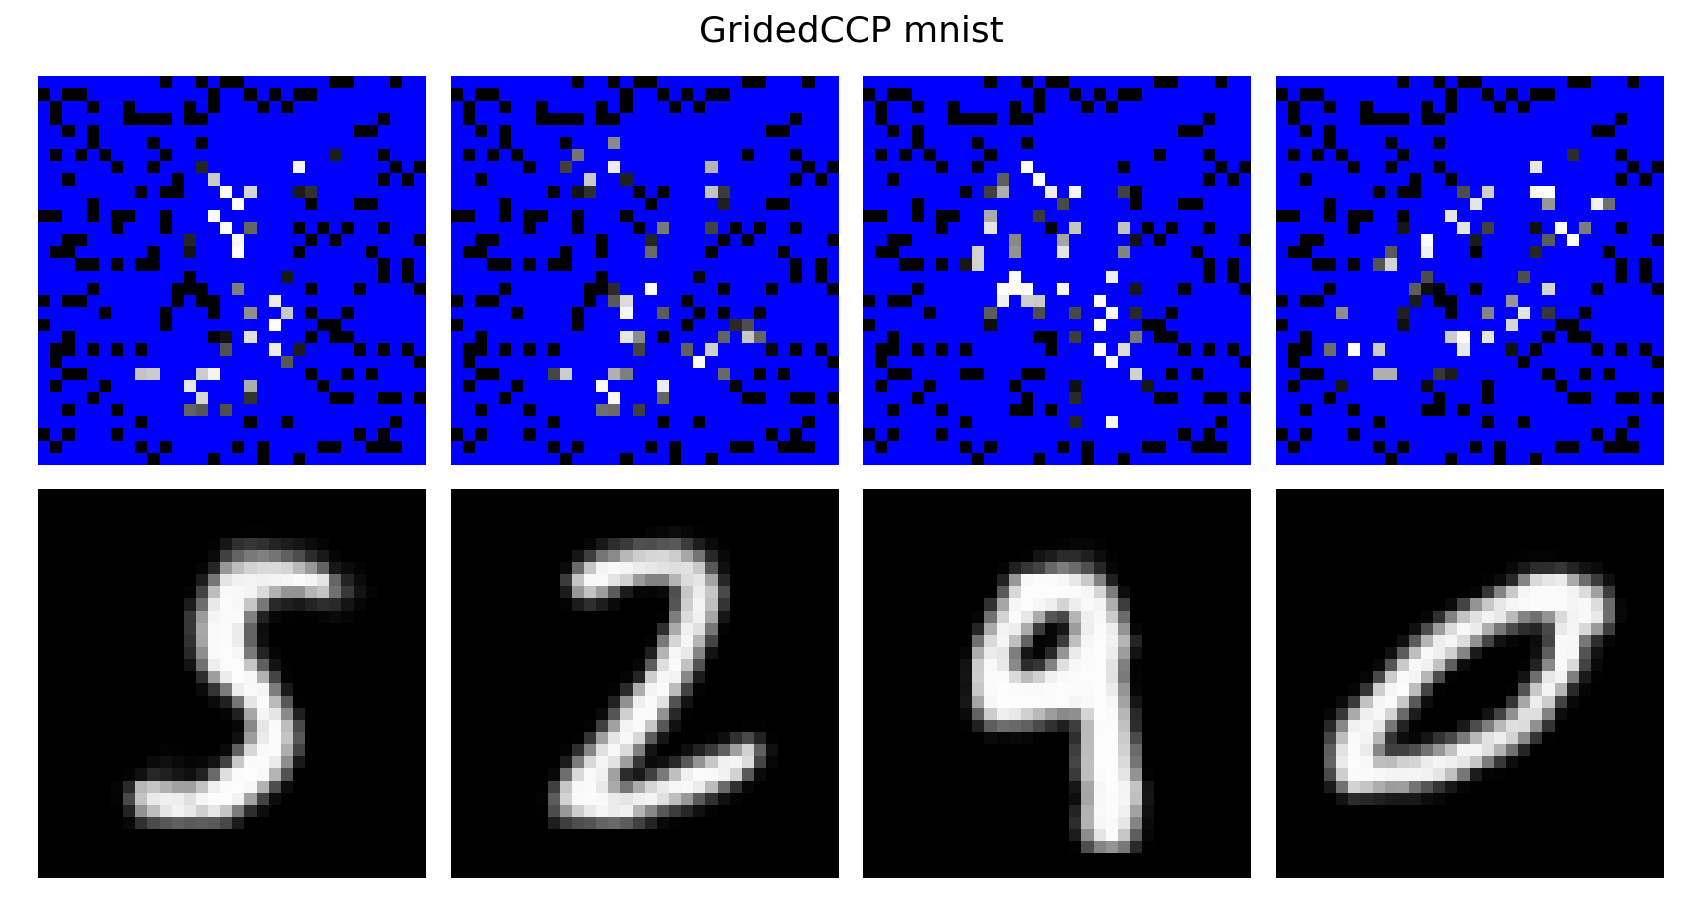

In [34]:
fig, axes = plt.subplots(1,1, figsize=(15, 9))
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    if data_name == "mnist":
        _=plot_posterior_img(data_test, 
                             GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.2, max_nnz=.2, is_batch_share=True),
                                                 target_masker=no_masker), 
                             trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                             MeanPredictor=VanillaPredictor,
                             n_plots=4,
                             is_uniform_grid=True,
                             ax=axes)

        axes.set_title("GridedCCP " + data_name, fontsize=18)

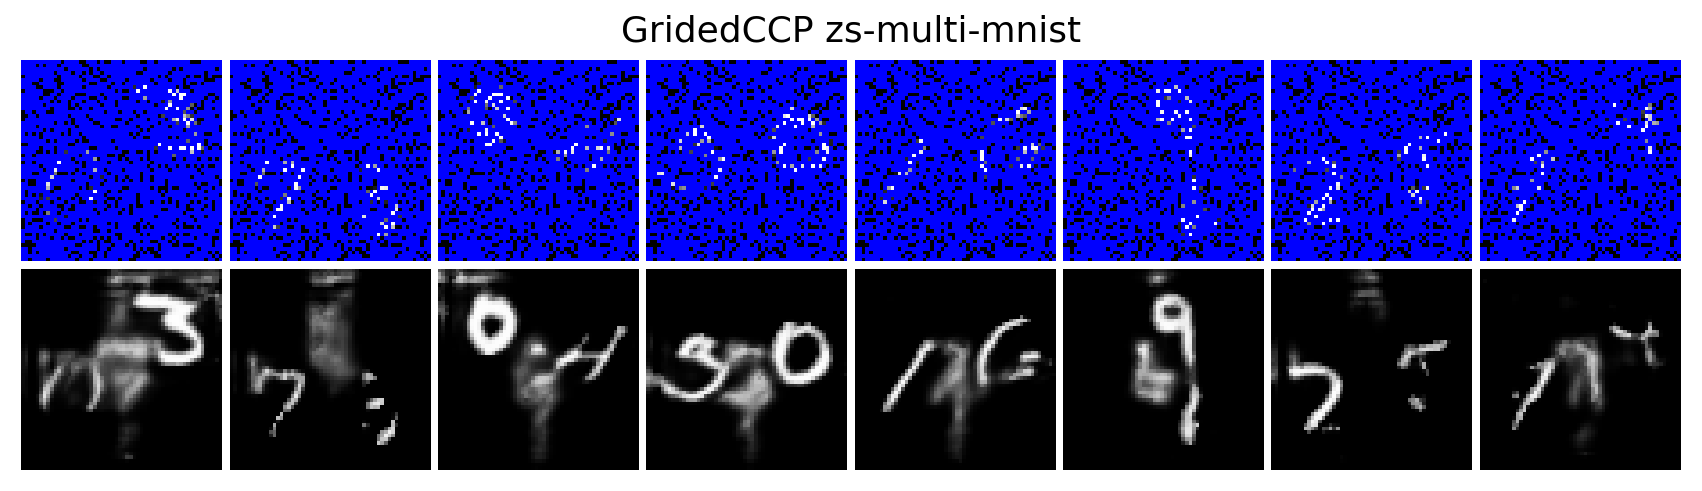

In [36]:
fig, axes = plt.subplots(1,1, figsize=(15, 9))
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    if data_name == "zs-multi-mnist":
        _=plot_posterior_img(data_test, 
                             GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.2, max_nnz=.2, is_batch_share=True),
                                                 target_masker=no_masker), 
                             trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                             MeanPredictor=AutoregressivePredictor,
                             n_plots=8,
                             is_uniform_grid=True,
                             ax=axes)

        axes.set_title("GridedCCP " + data_name, fontsize=18)

In [37]:
d=dict(a=1)

In [38]:
d.copy()

{'a': 1}

## Structured Missing

### Horizontal Half Mask

In [ ]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1),
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1),
                                             target_masker=no_masker), 
                         trainers_general['{}/AttnCNP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=False, # AttnCNP doesn't assume grid input
                         ax=axes[i])
    
    axes[i].set_title("AttnCNP " + data_name, fontsize=18)

### Vertical Half Mask

In [ ]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), # change dim=0 for vertical
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0),
                                         target_masker=no_masker), 
                         trainers_general['{}/AttnCNP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=False,
                         ax=axes[i])
    
    axes[i].set_title("AttnCNP " + data_name, fontsize=18)

# Autoregressive Inference 

Autoregressive is as James suggested : predict all neighbors (1 manhattan distance) of context, treat it as context, predict next neighbours.

In [ ]:
for data_name, test_data in test_datasets.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_grided.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.05, max_nnz=.05, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=AutoregressivePredictor,
                                     figsize=(6, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

In [ ]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(len(test_datasets),1, figsize=(15, 9))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), # change dim=0 for vertical
                                             target_masker=no_masker), 
                         trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedCCP " + data_name, fontsize=18)

# CelebA64

I did not plot all CelebA64, as not all models are trained yet. Here I show `GridedUnetCCP` which finished training.

In [ ]:
train_datasets64 = dict(celeba64=celeba64_train)
test_datasets64 = dict(celeba64=celeba64_test)

In [ ]:
trainers_grided64 = train_models(train_datasets64, 
                                 add_y_dim(dict(GridedUnetCCP=GridedUnetCCP), train_datasets64),
                                 NeuralProcessLoss,
                                 test_datasets=test_datasets64,
                                 chckpnt_dirname="results/neural_process_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True),
                                 patience=10,
                                 seed=123) 

## Oneshot Prediction

In [ ]:
for data_name, test_data in test_datasets64.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_grided64.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.1, max_nnz=.1, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=VanillaPredictor,
                                     figsize=(6, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

In [ ]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)

In [ ]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)

## Autoregressive Prediction

In [ ]:
for data_name, test_data in test_datasets64.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_grided64.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.1, max_nnz=.1, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=AutoregressivePredictor,
                                     figsize=(6, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

In [ ]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)

In [ ]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)